In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
# import folium

import json


import ast

import sys
import os


import matplotlib.gridspec as gridspec
import folium
from folium import FeatureGroup
from matplotlib import style
style.use('seaborn-darkgrid')


import keplergl



from datetime import datetime

from sklearn import preprocessing


%matplotlib inline
# sns.set_style("seaborn-darkgrid")

C:\Users\nshah12\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# read data

## K-means results

In [2]:
kmean_results = pd.read_csv(
    '_Data/Model results/kmean_predictions.csv')


kmean_results['StartTime_decimal'] = kmean_results.apply(
    lambda x: x['StartTime_decimal'] + 24
    if x['StartTime_decimal'] <= 6 else x['StartTime_decimal'],
    axis=1)

#add flag for trips starting or ending at Vanderbilt and Parks
kmean_results['VANDERBILT_trip'] = kmean_results.apply(
    lambda x: 1
    if (x['VANDERBILT_start'] == 1) | (x['VANDERBILT_end'] == 1) else 0,
    axis=1)


kmean_results['PARK_trip'] = kmean_results.apply(
    lambda x: 1
    if (x['PARK_start'] == 1) | (x['PARK_end'] == 1) else 0,
    axis=1)

print(kmean_results.shape)
print(kmean_results.columns)
kmean_results.head()

(1050041, 68)
Index(['Unnamed: 0', 'Unnamed: 0.1', 'trip_id', 'GRID_ID_start', 'GRID_ID_end',
       'enthropy_start', 'MEAN_CBD_start', 'MEAN_URBAN_start', 'MEAN_SU_start',
       'MEAN_RURAL_start', 'MEAN_POP_D_start', 'MEAN_EMP_D_start',
       'MEAN_PAKING_start', 'intersection_density_start', 'enthropy_end',
       'MEAN_CBD_end', 'MEAN_URBAN_end', 'MEAN_SU_end', 'MEAN_RURAL_end',
       'MEAN_POP_D_end', 'MEAN_EMP_D_end', 'MEAN_PAKING_end',
       'intersection_density_end', 'PARK_start', 'VANDERBILT_start',
       'NISSAN_start', 'PARK_end', 'VANDERBILT_end', 'NISSAN_end',
       'tripDistance_miles', 'tripDistance', 'tripDuration',
       'euclidean_distance', 'StartTime_decimal', 'route_directness_rawDist',
       'route_directness_trace', 'average_trip_speed_mph',
       'trip_start_week_no', 'trip_start_hour_no', 'StartTime_AMPeak',
       'StartTime_Day', 'StartTime_PMPeak', 'StartTime_Night', 'weekend_trip',
       'high_trip_count_day', 'DATE_str', 'PRCP', 'TAVG', 'kmeans

,Unnamed: 0,Unnamed: 0.1,trip_id,GRID_ID_start,GRID_ID_end,enthropy_start,MEAN_CBD_start,MEAN_URBAN_start,MEAN_SU_start,MEAN_RURAL_start,...,kmeans_12,kmeans_13,kmeans_14,kmeans_15,kmeans_16,kmeans_17,kmeans_18,kmeans_19,VANDERBILT_trip,PARK_trip
0,0,0,9,DN-110,DR-111,0.928214,0.90,0.00,0.0,0.0,...,6,6,13,13,14,14,14,17,0,0
1,1,1,10,DK-106,DL-107,0.598365,0.35,0.55,0.0,0.0,...,4,3,6,6,8,8,17,17,0,1
2,2,2,11,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,...,6,6,13,13,14,14,14,17,0,0
3,3,3,12,DM-110,DN-110,0.865962,0.90,0.00,0.0,0.0,...,6,6,13,13,14,14,14,14,0,0
4,4,4,13,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,...,6,6,13,13,14,14,14,17,0,0


## Trip data

In [3]:
mydateparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

trip_data = pd.read_csv(
    '_Data/trip data/start_end_points_cleaned.csv',
    parse_dates=['startDateTime'],
    date_parser=mydateparser)

trip_data.head()

C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,trip_id,startLatitude,startLongitude,endLatitude,endLongitude,weekend_trip,startDateTime,tripRoute
0,1,9,36.1651,-86.7785,36.1622,-86.7683,0,2018-09-01 12:13:22,"[[36.165096,-86.778367],[36.165091,-86.778374]..."
1,2,10,36.1760,-86.7871,36.1733,-86.7857,0,2018-09-01 12:14:46,"[[36.176036,-86.787034],[36.176036,-86.787034]..."
2,3,11,36.1643,-86.7770,36.1750,-86.7819,0,2018-09-01 12:15:11,"[[36.164271,-86.777062],[36.164271,-86.777062]..."
3,4,12,36.1642,-86.7811,36.1647,-86.7803,0,2018-09-01 12:46:21,"[[36.164203,-86.78109],[36.164203,-86.78109],[..."
4,5,13,36.1643,-86.7771,36.1749,-86.7819,0,2018-09-01 12:18:32,"[[36.164336,-86.777085],[36.164336,-86.777085]..."


# Visualizing clustering results

In [8]:
def plot_graph(cluster_df, selected_cluster, variable_to_plot, title, ax,
               plot_upper_bound, x_label):
    #PURPOSE: Plot kdeplot of a single variable for all cluster type
    #INPUT
    ####ax = axis of gridspec
    ####title: title of the plot
    ####cluster_df: Dataframe with cluster id
    ####selected_cluster: cluster to plot
    ####variable_to_plot: name of the variable to plot
    ####plot_upper_bound: upper bound of the plot
    #OUTPUT: plt plot

    #fig, ax = plt.subplots(figsize=(6,4))

    #run a loop for all the sorted unique values in cluster
    for i in sorted(cluster_df[selected_cluster].unique()):
        #plot kdeplot for each clusters in same plot
        sns.kdeplot(
            cluster_df[cluster_df[selected_cluster] == i][variable_to_plot],
            label=str('C' + str(i)),
            ax=ax)
    ax.set_title(title, fontsize=10)

    ax.legend(fontsize=8, ncol=2)

    ax.axis([0, plot_upper_bound, None, None])
    ax.set_ylabel('Probability', fontsize=9)
    ax.set_xlabel(x_label, fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=8)
    #return plt


def spyder_plot_for_cluster(cluster_results, cluster_var_col_name,
                            cluster_number, ax, plot_color, var_median,
                            var_mean):

    var_spyder_all = var_median + var_mean
    #slice variable of interest
    data_for_sypder_plot = cluster_results[var_spyder_median + var_spyder_mean]

    #     cluster_var_col_name = str('kmeans_' + str(kmeans_cluster_no))

    #standarize the data
    scaler = preprocessing.MinMaxScaler()
    data_for_sypder_plot_scaled = pd.DataFrame(
        scaler.fit_transform(data_for_sypder_plot), columns=var_spyder_all)
    data_for_sypder_plot_scaled[cluster_var_col_name] = cluster_results[
        cluster_var_col_name]

    #get dataframe of one cluster
    cluster = data_for_sypder_plot_scaled[
        data_for_sypder_plot_scaled[cluster_var_col_name] ==
        cluster_number][var_spyder_all]

    #     #standarize the data
    #     scaler = preprocessing.MinMaxScaler()
    #     cluster = pd.DataFrame(scaler.fit_transform(cluster_0), columns=var_spyder_all)

    labels = np.arange(1,
                       len(np.array(var_spyder_all)) + 1,
                       1)  #np.array(var_spyder_all)

    #concate mean and median columns and sum them to get one column
    stats = pd.concat([
        cluster.loc[:, var_spyder_median].median(axis=0),
        cluster.loc[:, var_spyder_mean].mean(axis=0)
    ],
                      axis=1)
    stats = stats.sum(axis=1)

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
    # close the plot
    stats = np.concatenate((stats, [stats[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig = plt.figure()
    #     ax = fig.add_subplot(111, polar=True)
    ax.plot(angles,
            stats,
            'o-',
            markersize=2,
            linewidth=1.5,
            color=plot_color,
            label=str('C' + str(cluster_number)))
    ax.fill(angles, stats, alpha=0.05)
    ax.set_thetagrids(angles[:19] * 180 / np.pi, labels)
    ax.set_yticklabels([])
    #     ax.set_title(str('C' + str(cluster_number)))
    ax.grid(True)
#     ax.legend()


In [9]:
var_spyder_median = [
    'tripDistance_miles',
    'tripDuration',
    'route_directness_trace',
    'average_trip_speed_mph',

        'TAVG',
    'MEAN_CBD_start',
    'MEAN_URBAN_start',
    'MEAN_POP_D_start',
    'MEAN_EMP_D_start',
    'MEAN_PAKING_start',
    #     'intersection_density_start',
    'enthropy_start',
    'MEAN_CBD_end',
    'MEAN_URBAN_end',
    'MEAN_POP_D_end',
    'MEAN_EMP_D_end',
    'MEAN_PAKING_end',
    #     'intersection_density_end',
    'enthropy_end'
]

var_spyder_mean = ['high_trip_count_day', 'weekend_trip']

var_spyder_all = var_spyder_median + var_spyder_mean

## Trip start time by clusters

### Clusterd by sequence

C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In

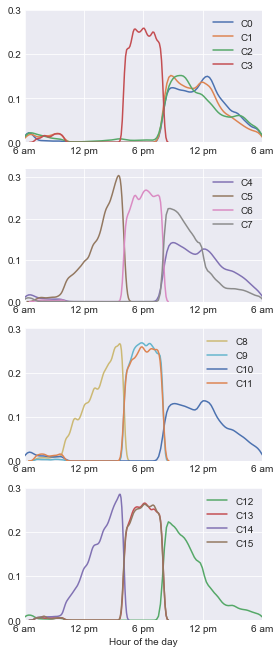

In [10]:
selected_cluster = 'kmeans_16'
total_clusters = int(selected_cluster[7:])
clusters_per_plot = 3
number_of_plot = 4
plot_split = [0, 3, 7, 11, 15]

style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(4, 9))
#fig.suptitle('K mean cluster 10')

gspec = gridspec.GridSpec(number_of_plot, 1)

#defind colour pallet
custom_palette = sns.color_palette("deep", total_clusters)

for i in np.arange(0, total_clusters, 1):
    if (i <= plot_split[1]):
        sns.kdeplot(kmean_results[kmean_results[selected_cluster] == i]
                    ['StartTime_decimal'],
                    clip=(0, 30),
                    label=str('C' + str(i)),
                    color=custom_palette[i],
                    ax=plt.subplot(gspec[0, 0]))

    elif (i <= plot_split[2]) & (i > plot_split[1]):
        sns.kdeplot(kmean_results[kmean_results[selected_cluster] == i]
                    ['StartTime_decimal'],
                    clip=(0, 30),
                    label=str('C' + str(i)),
                    color=custom_palette[i],
                    ax=plt.subplot(gspec[1, 0]))
    elif (i <= plot_split[3]) & (i > plot_split[2]):
        sns.kdeplot(kmean_results[kmean_results[selected_cluster] == i]
                    ['StartTime_decimal'],
                    clip=(0, 30),
                    label=str('C' + str(i)),
                    color=custom_palette[i],
                    ax=plt.subplot(gspec[2, 0]))
    elif (i <= plot_split[4]) & (i > plot_split[3]):
        sns.kdeplot(kmean_results[kmean_results[selected_cluster] == i]
                    ['StartTime_decimal'],
                    clip=(0, 30),
                    label=str('C' + str(i)),
                    color=custom_palette[i],
                    ax=plt.subplot(gspec[3, 0]))

    plt.xlim(6, 30)
    plt.xticks(np.arange(6, 31, 6),['6 am','12 pm','6 pm','12 pm', '6 am'])
    

#     plt.xticks(np.arange(6, 25, 6))
    plt.yticks(np.arange(0, 0.4, 0.1))

plt.tight_layout()
plt.xlabel('Hour of the day')

plt.savefig(str('results/cluster_time_of_day.png'), dpi=900)

# plt.savefig('plots/DailyTrips_Year.png', dpi=900)

### Clustered by group

C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In

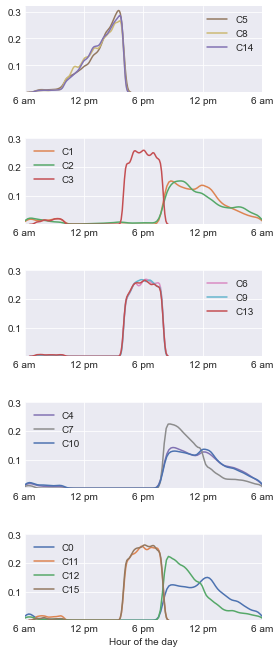

In [11]:
selected_cluster = 'kmeans_16'
total_clusters = int(selected_cluster[7:])
number_of_plot = 5


#group clusters by id
dayTime_ShortErrand=[5,8,14]
utilitarian = [1,2,3]
evening_Social = [6,9,13]
entertainment_District = [4,7,10]
recreational =[0,11,12,15]
grouped_clusters = [
    dayTime_ShortErrand, utilitarian, evening_Social, entertainment_District,
    recreational
]


style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(4, 9))
gspec = gridspec.GridSpec(number_of_plot, 1)

#defind colour pallet
custom_palette = sns.color_palette("deep", total_clusters)


grouped_clusters = [
    dayTime_ShortErrand, utilitarian, evening_Social, entertainment_District,
    recreational
]

for grouped_id in np.arange(len(grouped_clusters)):
    for individual_cluster in grouped_clusters[grouped_id]:
        sns.kdeplot(kmean_results[kmean_results[selected_cluster] == individual_cluster]
            ['StartTime_decimal'],
            clip=(0, 30),
            label=str('C' + str(individual_cluster)),
            color=custom_palette[individual_cluster],
            ax=plt.subplot(gspec[grouped_id, 0]))

    #add axis labels and ticks
    plt.xlim(6, 30)
    plt.xticks(np.arange(6, 31, 6),['6 am','12 pm','6 pm','12 pm', '6 am'])
   
#     plt.xticks(np.arange(6, 25, 6))
    plt.yticks(np.arange(0, 0.4, 0.1), ['','0.1','0.2','0.3'])

plt.tight_layout(h_pad=3.0)
plt.xlabel('Hour of the day')

plt.savefig(str('results/cluster_time_of_day_V2-grouped.png'),bbox_inchs='tight', dpi=900)



## Radar plot for cluster attributes

https://www.kaggle.com/typewind/draw-a-radar-chart-with-python-in-a-simple-way/data

### clustered by sequence

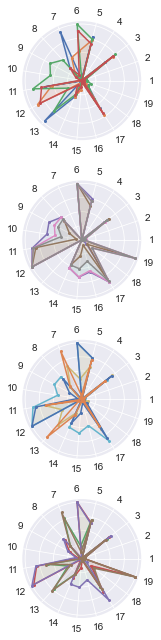

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
fig = plt.figure(figsize=(4, 9))
#fig.suptitle('K mean cluster 10')

gspec = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gspec[0, 0], polar=True)
ax1 = plt.subplot(gspec[1, 0], polar=True)
ax2 = plt.subplot(gspec[2, 0], polar=True)
ax3 = plt.subplot(gspec[3, 0], polar=True)

#defind colour pallet
custom_palette = sns.color_palette("deep", total_clusters)

for i in np.arange(0, total_clusters, 1):
    if (i <= plot_split[1]):
        spyder_plot_for_cluster(kmean_results,
                        selected_cluster,
                        i,
                        ax0,
                        custom_palette[i],
                        var_spyder_median,
                        var_spyder_mean)
    elif (i <= plot_split[2]) & (i > plot_split[1]):
        spyder_plot_for_cluster(kmean_results,
                selected_cluster,
                i,
                ax1,
                custom_palette[i],
                var_spyder_median,
                var_spyder_mean)
    elif (i <= plot_split[3]) & (i > plot_split[2]):
        spyder_plot_for_cluster(kmean_results,
                selected_cluster,
                i,
                ax2,
                custom_palette[i],
                var_spyder_median,
                var_spyder_mean)        
    elif (i <= plot_split[4]) & (i > plot_split[3]): 
        spyder_plot_for_cluster(kmean_results,
                selected_cluster,
                i,
                ax3,
                custom_palette[i],
                var_spyder_median,
                var_spyder_mean)        
fig.tight_layout()       

fig.savefig(str('results/cluster_attributes.png'),dpi=900)

### Clustered by group

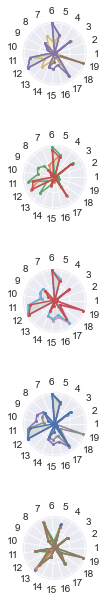

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [13]:
style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(4, 9))

#defind colour pallet
custom_palette = sns.color_palette("deep", total_clusters)



gspec = gridspec.GridSpec(5, 1)
ax0 = plt.subplot(gspec[0, 0], polar=True)
ax1 = plt.subplot(gspec[1, 0], polar=True)
ax2 = plt.subplot(gspec[2, 0], polar=True)
ax3 = plt.subplot(gspec[3, 0], polar=True)
ax4 = plt.subplot(gspec[4, 0], polar=True)

ax=[ax0, ax1, ax2, ax3, ax4]


custom_palette = sns.color_palette("deep", total_clusters)

for grouped_id in np.arange(len(grouped_clusters)):
    for individual_cluster in grouped_clusters[grouped_id]:
        #defind colour pallet
        spyder_plot_for_cluster(kmean_results,
                        selected_cluster,
                        individual_cluster,
                        ax[grouped_id],
                        custom_palette[individual_cluster],
                        var_spyder_median,
                        var_spyder_mean)

fig.tight_layout(pad=3)

fig.savefig(str('results/cluster_attributes_v2-grouped.png'), dpi=900)

# plt.savefig('plots/DailyTrips_Year.png', dpi=900)

In [14]:
rename_variables = {
    'tripDistance_miles': 'Trip distance (miles)',
    'tripDuration': 'Trip duration (minutes)',
    'route_directness_trace': 'Route directness ratio',
    'average_trip_speed_mph': 'Average trip speed (mph)',
    'high_trip_count_day': 'Trips on special event',
    'weekend_trip': 'Weekend trips',
    'StartTime_AMPeak': 'Trip during 7 am and 10 am',
    'StartTime_Day': 'Trip during 10 am and 4 pm',
    'StartTime_PMPeak': 'Trip during 4 pm and 8 pm',
    'StartTime_Night': 'Trip during 8 pm and 7 am',
    'PRCP': 'Average daily precipitation',
    'TAVG': 'Average daily temperature',
    'MEAN_CBD_start': 'Proportion of CBD land use at origin',
    'MEAN_URBAN_start': 'Proportion of urban land use at origin',
    'MEAN_SU_start': 'Proportion of sub-urban land use at origin',
    'MEAN_RURAL_start': 'Proportion of rural land use at origin',
    'MEAN_POP_D_start': 'Average population density at origin',
    'MEAN_EMP_D_start': 'Average employment density at origin',
    'MEAN_PAKING_start': 'Average parking density at origin',
    'intersection_density_start':
    'Intersection density (per sq. miles) at origin',
    'enthropy_start': 'Entropy at origin',
    'MEAN_CBD_end': 'Proportion of CBD land use at destination',
    'MEAN_URBAN_end': 'Proportion of urban land use at destination',
    'MEAN_SU_end': 'Proportion of sub-urban land use at destination',
    'MEAN_RURAL_end': 'Proportion of rural land use at destination',
    'MEAN_POP_D_end': 'Average population density at destination',
    'MEAN_EMP_D_end': 'Average employment density at destination',
    'MEAN_PAKING_end': 'Average parking density at destination',
    'intersection_density_end':
    'Intersection density (per sq. miles) at destination',
    'enthropy_end': 'Entropy at destination'
}

for x,y in zip( np.arange(1,len(np.array(var_spyder_all))+1,1),np.array(var_spyder_all)):
    print('{0}: {1}'.format(x,rename_variables[y]))

1: Trip distance (miles)
2: Trip duration (minutes)
3: Route directness ratio
4: Average trip speed (mph)
5: Average daily temperature
6: Proportion of CBD land use at origin
7: Proportion of urban land use at origin
8: Average population density at origin
9: Average employment density at origin
10: Average parking density at origin
11: Entropy at origin
12: Proportion of CBD land use at destination
13: Proportion of urban land use at destination
14: Average population density at destination
15: Average employment density at destination
16: Average parking density at destination
17: Entropy at destination
18: Trips on special event
19: Weekend trips


# Redefine clusters

https://www.youtube.com/watch?v=T2mQiesnx8s

In [15]:
day_errand = [5, 8, 14]  #1
utilitarian_trips = [1, 2, 3]  #2
social = [6, 9, 13]  #3
bar_hopping = [4, 7, 10]  #4
social_recreational = [0, 11, 12, 15]  #5

reclassify_cluster_label=['Daytime short errand', 'Utilitarian', 'Evening social',
                         'Night-time Entertainment District', 'Recreational']


def reclassify_cluster(cluster_value_for_reclassify):
    if cluster_value_for_reclassify in day_errand:
        return 0
    if cluster_value_for_reclassify in utilitarian_trips:
        return 1
    if cluster_value_for_reclassify in social:
        return 2
    if cluster_value_for_reclassify in bar_hopping:
        return 3
    if cluster_value_for_reclassify in social_recreational:
        return 4




kmean_results['reclassified_cluster'] = kmean_results.apply(
    lambda x: reclassify_cluster(x['kmeans_16']), axis=1)

kmean_results.head()

,Unnamed: 0,Unnamed: 0.1,trip_id,GRID_ID_start,GRID_ID_end,enthropy_start,MEAN_CBD_start,MEAN_URBAN_start,MEAN_SU_start,MEAN_RURAL_start,...,kmeans_13,kmeans_14,kmeans_15,kmeans_16,kmeans_17,kmeans_18,kmeans_19,VANDERBILT_trip,PARK_trip,reclassified_cluster
0,0,0,9,DN-110,DR-111,0.928214,0.90,0.00,0.0,0.0,...,6,13,13,14,14,14,17,0,0,0
1,1,1,10,DK-106,DL-107,0.598365,0.35,0.55,0.0,0.0,...,3,6,6,8,8,17,17,0,1,0
2,2,2,11,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,...,6,13,13,14,14,14,17,0,0,0
3,3,3,12,DM-110,DN-110,0.865962,0.90,0.00,0.0,0.0,...,6,13,13,14,14,14,14,0,0,0
4,4,4,13,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,...,6,13,13,14,14,14,17,0,0,0


## Regrouped cluster results in table 

In [16]:
var_spyder_all = var_spyder_median + var_spyder_mean

cluster_number = 16
selected_cluster_to_group = ['reclassified_cluster']



#descriptive stats
summary_median = kmean_results[var_spyder_median +
                               selected_cluster_to_group].groupby(selected_cluster_to_group).agg(
                                   [np.mean])
summary_mean = kmean_results[var_spyder_mean +
                             selected_cluster_to_group].groupby(selected_cluster_to_group).agg(
                                 [np.mean])

summary = pd.concat([summary_median, summary_mean], axis=1)


total_special_trips=kmean_results.groupby(selected_cluster_to_group[0])['high_trip_count_day'].sum().sum()
special_trips_by_cluster=kmean_results.groupby(selected_cluster_to_group[0])['high_trip_count_day'].sum()
summary['proportion_of_special_day_trip'] = special_trips_by_cluster/total_special_trips*100

vanderbilt_trips=kmean_results.groupby(selected_cluster_to_group[0])['VANDERBILT_trip'].sum().sum()
vanderbilt_by_cluster=kmean_results.groupby(selected_cluster_to_group[0])['VANDERBILT_trip'].sum()
summary['proportion_of_vanderbilt_trip'] = vanderbilt_by_cluster/vanderbilt_trips*100

park_trips=kmean_results.groupby(selected_cluster_to_group[0])['PARK_trip'].sum().sum()
park_by_cluster=kmean_results.groupby(selected_cluster_to_group[0])['PARK_trip'].sum()
summary['proportion_of_park_trip'] = park_by_cluster/park_trips*100

#add proportion column
summary['proportion_of_trips'] = kmean_results.groupby(
    selected_cluster_to_group[0]).size() / len(kmean_results) * 100
# summary['proportion_of_trips'] = kmean_results.groupby(
#     selected_cluster_to_group[0]).size() / len(kmean_results) * 100

total_VMT=kmean_results.groupby(selected_cluster_to_group[0])['tripDistance_miles'].sum().sum()
total_VMT_by_cluster=kmean_results.groupby(selected_cluster_to_group[0])['tripDistance_miles'].sum()
summary['proportion_by_VMT'] = total_VMT_by_cluster/total_VMT*100

total_duration=kmean_results.groupby(selected_cluster_to_group[0])['tripDuration'].sum().sum()
total_duration_by_cluster=kmean_results.groupby(selected_cluster_to_group[0])['tripDuration'].sum()
summary['proportion_by_duration'] = total_duration_by_cluster/total_duration*100



summary=summary.transpose().rename(index=rename_variables)

summary.to_csv(
    str('results/regrouped_results.csv'))

summary

,reclassified_cluster,0,1,2,3,4
Trip distance (miles),mean,0.470484,0.884853,0.803258,0.705161,0.811433
Trip duration (minutes),mean,15.239223,16.516848,17.781913,15.880531,16.994583
Route directness ratio,mean,0.581140,0.644765,0.526038,0.541695,0.481728
Average trip speed (mph),mean,2.276594,3.539348,2.949234,3.059160,3.097141
Average daily temperature,mean,61.258514,64.515574,65.515719,66.258814,65.965161
Proportion of CBD land use at origin,mean,0.646618,0.661170,0.853409,0.873317,0.182512
Proportion of urban land use at origin,mean,0.247391,0.224419,0.038193,0.019690,0.710594
Average population density at origin,mean,7707.693385,6204.372244,10075.698092,10108.879684,5508.777027
Average employment density at origin,mean,62585.677576,59247.409971,106301.742545,111923.472002,14411.825312
Average parking density at origin,mean,9866.506977,9799.121058,19185.282706,20171.779417,440.635920


## Temporal distrubution

In [17]:
selected_cluster = 'kmeans_16'
rolling_avg_data = pd.merge(kmean_results[['trip_id', selected_cluster]],
                          trip_data[['trip_id', 'startDateTime']],
                          on='trip_id',
                          how='inner').set_index('startDateTime')


rolling_avg_data['reclassified_cluster'] = rolling_avg_data.apply(
    lambda x: reclassify_cluster(x[selected_cluster]), axis=1)


rolling_avg_data1=rolling_avg_data.reset_index()






frame_reclassify = {}
for i in np.arange(0, int(len(reclassify_cluster_label)), 1):
#     print(i)
    frame_reclassify.update({
        str(reclassify_cluster_label[i]):
        rolling_avg_data[rolling_avg_data['reclassified_cluster'] ==
                         i].index.value_counts().resample('D').sum()
    })
    
rolling_avg_df = pd.DataFrame(frame_reclassify,index=pd.date_range('2018-9-1', periods=365, freq='D'))
rolling_avg_df = rolling_avg_df.fillna(0)
rolling_avg_df.head()

,Daytime short errand,Utilitarian,Evening social,Night-time Entertainment District,Recreational
2018-09-01,136.0,2.0,374.0,1.0,86.0
2018-09-02,226.0,0.0,153.0,3.0,61.0
2018-09-03,164.0,78.0,146.0,1.0,70.0
2018-09-04,71.0,20.0,49.0,7.0,8.0
2018-09-05,49.0,31.0,66.0,1.0,23.0


### Time of the year

#### by numbers

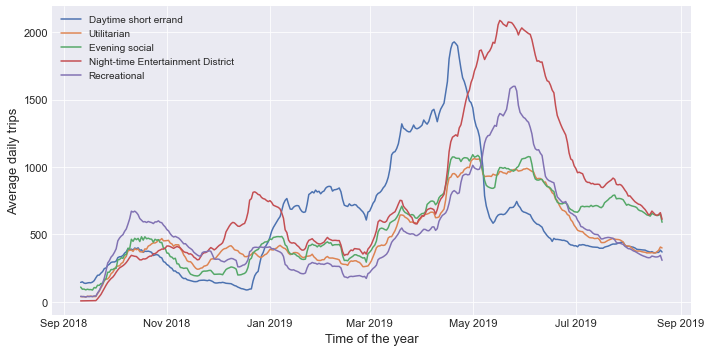

In [18]:
style.use('seaborn-darkgrid')
sns.set_palette("deep")
from matplotlib.dates import DateFormatter
# custom_palette=sns.color_palette("deep", 5)
fig, ax = plt.subplots(figsize=(10, 5))
for i in rolling_avg_df.columns:
    plt.plot(rolling_avg_df[i].rolling(21,center=True).mean(), label=i)

date_form = DateFormatter("%b %Y")
ax.xaxis.set_major_formatter(date_form)

#axis label
plt.xlabel('Time of the year', fontsize=13)
plt.ylabel('Average daily trips', fontsize=13)

_ = ax.tick_params(axis='both', which='major', labelsize=11)
_ = ax.tick_params(axis='both', which='minor', labelsize=11)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('results/TemporalDistribution_RegroupedCluster_TimeOfYear.png', dpi=300)
plt.legend()

#### by percentage

In [19]:
total_trips_by_grouped_cluster=kmean_results.groupby(
    selected_cluster_to_group[0]).size()

rolling_avg_by_percent=rolling_avg_df.div(list(total_trips_by_grouped_cluster))*100

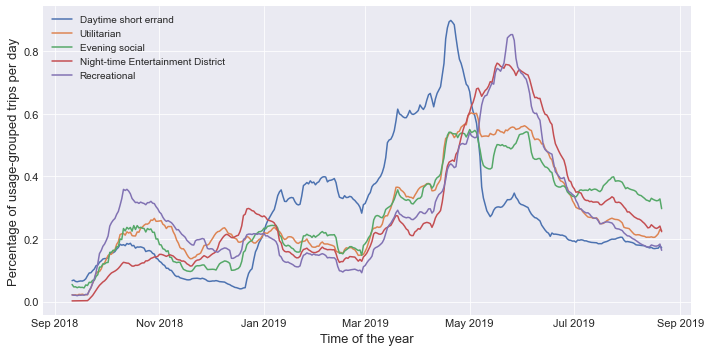

In [20]:
style.use('seaborn-darkgrid')
sns.set_palette("deep")
from matplotlib.dates import DateFormatter
# custom_palette=sns.color_palette("deep", 5)
fig, ax = plt.subplots(figsize=(10, 5))
for i in rolling_avg_df.columns:
    plt.plot(rolling_avg_by_percent[i].rolling(21, center=True).mean(),
             label=i)

date_form = DateFormatter("%b %Y")
ax.xaxis.set_major_formatter(date_form)

#axis label
plt.xlabel('Time of the year', fontsize=13)
plt.ylabel('Percentage of usage-grouped trips per day', fontsize=13)

_ = ax.tick_params(axis='both', which='major', labelsize=11)
_ = ax.tick_params(axis='both', which='minor', labelsize=11)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('results/TemporalDistribution_RegroupedCluster_TimeOfYearV2.png',
            dpi=300)
plt.legend()

### Day of the week

In [21]:
# week_no_value=6
def relabeled_weekno(week_no_value):
    if week_no_value<4:
        return 0
    elif week_no_value==4:
        return 1
    else:
        return week_no_value-3
    

index_array = [np.arange(0, 4, 1), np.arange(0, 24, 1)]
cluster_time_summary = pd.DataFrame(index=pd.MultiIndex.from_product(
    index_array, names=('week_day', 'hour_no')))

data_all_trips_reidentified = rolling_avg_data1.reset_index()
# kmean_results['reclassified_cluster'].unique()
cluster_time_summary
for i in np.arange(0, int(len(reclassify_cluster_label)), 1):
    plot_data = data_all_trips_reidentified[
        data_all_trips_reidentified['reclassified_cluster'] == i]

    plot_data_count = pd.DataFrame(
        plot_data['startDateTime'].value_counts().resample(
            'H').count()).rename(columns={
                'startDateTime': reclassify_cluster_label[i]
            }).reset_index()

    # #creating column for weekday no

    plot_data_count['week_day'] = plot_data_count.apply(
        lambda x: relabeled_weekno(x['index'].weekday()), axis=1)
    plot_data_count['hour_no'] = plot_data_count.apply(
        lambda x: x['index'].hour, axis=1)

    plot_data_summary = plot_data_count.groupby(
        ['week_day', 'hour_no'])[reclassify_cluster_label[i]].mean()

    cluster_time_summary = pd.merge(cluster_time_summary,
                                    plot_data_summary,
                                    on=['week_day', 'hour_no'],
                                    how='left')
# cluster_time_summary = cluster_time_summary.fillna(0)
cluster_time_summary

Daytime short errand  Utilitarian  Evening social  \
week_day hour_no                                                      
0        0                         0.0    31.889423        0.000000   
         1                         0.0    22.322115        0.000000   
         2                         0.0    15.913462        0.000000   
         3                         0.0    13.807692        0.000000   
         4                         0.0     9.908654        0.000000   
...                                ...          ...             ...   
3        19                        0.0     0.000000      210.173077   
         20                        0.0    10.750000        0.000000   
         21                        0.0     9.711538        0.000000   
         22                        0.0     8.230769        0.000000   
         23                        0.0     7.500000        0.000000   

                  Night-time Entertainment District  Recreational  
week_day hour_no                                                   
0        0                                65.759615     22.250000  
         1                                48.711538     16.288462  
         2                                38.072115     10.740385  
         3                                32.975962      7.836538  
         4                                21.927885      5.408654  
...                                             ...           ...  
3        19                                0.000000     80.153846  
         20                              165.173077     83.461538  
         21                              152.673077     76.980769  
         22                              132.403846     66.461538  
         23                              112.192308     49.865385  

[96 rows x 5 columns]

C:\Users\nshah12\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


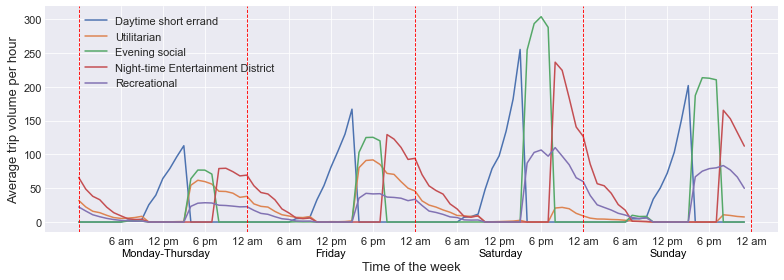

In [23]:
#creating column for weekday no
# data['week_no'] = data.apply(lambda x: x['startDateTime'].weekday(), axis=1)
# data['hour_no'] = data.apply(lambda x: x['startDateTime'].hour, axis=1)
style.use('seaborn-darkgrid')
sns.set_palette("deep")

fig, ax = plt.subplots(figsize=(11, 4))

# for i in np.arange(0, total_clusters, 1):
#     plot_data = kmean_results[kmean_results[selected_cluster] == i]

#     plot_data.groupby(['trip_start_week_no', 'trip_start_hour_no'
#                        ]).size().plot(ax=ax)

cluster_time_summary.plot(ax=ax)

for x in np.arange(0, 24 * 5, 24):
    ax.axvline(x=x, color='red', linewidth=0.9, linestyle='--')

day_label = ['Monday-Thursday', 'Friday', 'Saturday', 'Sunday']
day_label_position=[6,33.8,57.1,81.5]

for x in np.arange(1, 5, 1):
    ax.text(day_label_position[x - 1],#-20 + 0.5 * len(day_label[x - 1]) + 24 * x,
            -50,
            day_label[x - 1],
            color='black',
            fontsize=11)

# axis tick label
# ax.set_yticklabels['12,24']

# ax.xaxis.set_minor_locator(MultipleLocator(6))
# ax.xaxis.set_major_locator(MultipleLocator(12))
# ax.set_xticklabels([0, 0, 12, 24, 12, 24, 12, 24, 12, 24, 24, 24, 24])

plt.xticks(np.arange(0,24*4+6,6),['']+['6 am','12 pm','6 pm','12 am']*4)

#axis label
plt.xlabel('Time of the week', fontsize=13, labelpad=15)
plt.ylabel('Average trip volume per hour', fontsize=13)

_ = ax.tick_params(axis='both', which='major', labelsize=11)
_ = ax.tick_params(axis='both', which='minor', labelsize=11)
plt.legend(fontsize=11,loc='upper left', bbox_to_anchor=(0.04, 1))
plt.tight_layout()
plt.savefig('results/TemporalDistribution_RegroupedCluster_TimeOfWeek_V2.png', dpi=300)



## Spatial Distribution

### All trips

In [ ]:
all_cluster_start = trip_data[['trip_id', 'startLatitude', 'startLongitude']]

# all_cluster_end = trip_data[['trip_id', 'endLatitude', 'endLongitude']]

# read last config
with open(str('_Data/kepler config/config_hist_all.json'), 'r') as fp:
    config_1 = json.load(fp)


map_start = keplergl.KeplerGl(height=600,
                              data={'data': all_cluster_start},
                              config=config_1)
# this will save map with provided data and config
map_start.save_to_html(file_name=str('results/spatial plots/all_start_heatmap.html'),
                       read_only=False)


#end points
all_cluster_end = trip_data[['trip_id', 'endLatitude', 'endLongitude']]
rep = {
    "data_start": 'data_end',
    "startLatitude": "endLatitude",
    "startLongitude": "endLongitude",
    "start": "end"
}


def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text


config_end = json.loads(replace_all(json.dumps(config_1), rep))

map_end = keplergl.KeplerGl(height=600,
                            data={'data': all_cluster_end},
                            config=config_end)
# this will save map with provided data and config
map_end.save_to_html(file_name=str('results/spatial plots/all_end_heatmap.html'),
                     read_only=False)

### Clusters

In [ ]:
for cluster_no in np.arange(0, int(len(reclassify_cluster_label)), 1):
#     cluster_no=0
    #slice trips in cluster
    reclass_cluster = rolling_avg_data[rolling_avg_data.reclassified_cluster ==
                                       cluster_no]

    #merge with start and end points
    reclass_cluster_start = pd.merge(
        reclass_cluster, trip_data, on='trip_id',
        how='left')[['trip_id', 'startLatitude', 'startLongitude']]

    reclass_cluster_end = pd.merge(reclass_cluster,
                                   trip_data,
                                   on='trip_id',
                                   how='left')[[
                                       'trip_id', 'endLatitude', 'endLongitude'
                                   ]]

    plot_data_name = str('Reclassfied_cluster' + str(cluster_no))

    # read last config
    with open(str('_Data/kepler config/config_hist.json'), 'r') as fp:
        config_1 = json.load(fp)
        
    config_start = json.loads(
        json.dumps(config_1).replace('Reclassfied_cluster0', plot_data_name))

    #for end config
    rep = {
        "Reclassfied_cluster0": plot_data_name,
        "startLatitude": "endLatitude",
        "startLongitude": "endLongitude",
        "start": "end"
    }

    def replace_all(text, dic):
        for i, j in dic.items():
            text = text.replace(i, j)
        return text

    config_end = json.loads(replace_all(json.dumps(config_1), rep))

    map_start = keplergl.KeplerGl(height=600,
                                  data={plot_data_name: reclass_cluster_start},
                                  config=config_start)
    # this will save map with provided data and config
    map_start.save_to_html(file_name=str('results/spatial plots/Regrouped_C'+str(cluster_no) + '_start_heatmap.html'),
                           read_only=False)

    map_end = keplergl.KeplerGl(height=600,
                                data={plot_data_name: reclass_cluster_end},
                                config=config_end)
    # this will save map with provided data and config
    map_end.save_to_html(file_name=str('results/spatial plots/Regrouped_C'+str(cluster_no) + '_end_heatmap.html'),
                         read_only=False)
    map_start

In [ ]:
map_start

In [ ]:
# ##SAVE CONFIG

# config_hist = map_start.config

# #save the current config
# with open(
#         '_Data/kepler config/config_hist.json',
#         'w') as fp:
#     json.dump(config_hist, fp)

### OD matrix

In [ ]:
for cluster_no in np.arange(0, int(len(reclassify_cluster_label)), 1):
    # cluster_no=3
    #slice trips in cluster
    reclass_cluster = rolling_avg_data[rolling_avg_data.reclassified_cluster ==
                                       cluster_no]

    #merge with start and end points
    reclass_cluster = pd.merge(reclass_cluster,
                               trip_data,
                               on='trip_id',
                               how='left')[[
                                   'trip_id', 'startLatitude',
                                   'startLongitude', 'endLatitude',
                                   'endLongitude'
                               ]].sample(1000)

    plot_data_name = str('Reclassfied_cluster' + str(cluster_no))

    # read last config
    with open('config_OD.json', 'r') as fp:
        config_OD = json.load(fp)
    # config_OD = json.loads(json.dumps(config_1).replace('Reclassfied_cluster0',plot_data_name))

    #for end config
    rep = {
        "Reclassfied_cluster0": plot_data_name,
    }

    #     def replace_all(text, dic):
    #         for i, j in dic.items():
    #             text = text.replace(i, j)
    #         return text

    config_OD_edit = json.loads(replace_all(json.dumps(config_OD), rep))

    map_OD = keplergl.KeplerGl(height=600,
                               data={plot_data_name: reclass_cluster},
                               config=config_OD_edit)
    # this will save map with provided data and config
    map_OD.save_to_html(file_name=str('results/spatial plots/OD_' +
                                      str(cluster_no) + '.html'),
                        read_only=False)

In [ ]:
# map_start.config

# ##SAVE CONFIG

# config_OD = map_start.config

# #save the current config
# with open(
#         '../1_Data/Model results/kmeans/aggressive_cleaning/Visualization/reclassified_kepler/config_OD.json',
#         'w') as fp:
#     json.dump(config_OD, fp)

### Data for Chord diagram

In [83]:
#slice data
kmeans_results_export = kmean_results[['trip_id', 'reclassified_cluster']]

#label dictionary
regrouped_label_dict = {
    0: 'Daytime short errand',
    1: 'Utilitarian',
    2: 'Evening social',
    3: 'Night-time Entertainment District',
    4: 'Recreational'
}

kmeans_results_export['regrouped_cluster_label'] = kmeans_results_export[
    'reclassified_cluster'].map(regrouped_label_dict)

kmeans_results_export=kmeans_results_export.drop(columns=['reclassified_cluster'])
kmeans_results_export.head()

C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,trip_id,regrouped_cluster_label
0,9,Daytime short errand
1,10,Daytime short errand
2,11,Daytime short errand
3,12,Daytime short errand
4,13,Daytime short errand


In [84]:
# Landuse classification by grid
grid_clf=gpd.read_file('_Data/Landuse data/Shapefiles/LandUse_Classification.shp')
grid_clf_byGrid=grid_clf[['Fishnet_25','Landuse']]
grid_clf_byGrid.head()

,Fishnet_25,Landuse
0,CN-114,commercial
1,CO-111,commercial
2,CO-112,commercial
3,CO-113,commercial
4,CO-124,commercial


In [89]:
#grid id for trip origin and destination
trip_grid = gpd.read_file('_Data/Landuse data/Shapefiles/Start_end_grid_AllSegment.shp')
trip_grid=trip_grid[['trip_id', 'GRID_ID','GRID_ID_1']].rename(columns={'GRID_ID':'Origin_GRID',
                                                             'GRID_ID_1':'Destination_GRID'})

,trip_id,Origin_GRID,Destination_GRID
0,4902,BF-140,BE-140
1,4920,BF-140,BE-140
2,4774,CF-134,CF-134
3,4780,CF-134,CF-134
4,4560,CZ-133,DM-125
...,...,...,...
1017445,1165280,None,DP-111
1017446,1209229,None,DP-112
1017447,1309005,None,DQ-101
1017448,1372127,None,DO-111


In [99]:
#merge
chord_diagram_df = pd.merge(kmeans_results_export,
                            trip_grid,
                            on='trip_id',
                            how='left')
chord_diagram_df['Origin_Landuse'] = chord_diagram_df['Origin_GRID'].map(
    dict(dict(grid_clf_byGrid.values)))
chord_diagram_df['Distination_Landuse'] = chord_diagram_df['Destination_GRID'].map(
    dict(dict(grid_clf_byGrid.values)))
chord_diagram_df

,trip_id,regrouped_cluster_label,Origin_GRID,Destination_GRID,Origin_Landuse,Distination_Landuse
0,9,Daytime short errand,DN-110,DR-111,downtown,others
1,10,Daytime short errand,DK-106,DL-107,park,park
2,11,Daytime short errand,DO-110,DM-106,park,others
3,12,Daytime short errand,DM-110,DN-110,park,downtown
4,13,Daytime short errand,DO-110,DM-106,park,others
...,...,...,...,...,...,...
1050036,1547638,Utilitarian,DG-116,DC-117,vanderbilt,park
1050037,1547639,Night-time Entertainment District,DL-114,DP-113,commercial,downtown
1050038,1547644,Night-time Entertainment District,DN-111,DL-110,downtown,park
1050039,1547648,Utilitarian,DD-118,DE-116,vanderbilt,vanderbilt


In [113]:
crosstab_Landuse=pd.crosstab(chord_diagram_df['Origin_Landuse'],
                            [chord_diagram_df['Distination_Landuse']],
                            margins=False)
crosstab_Landuse.to_csv('_Data/Chord diagram/crosstab_landuse.csv')
crosstab_Landuse

Distination_Landuse,commercial,downtown,others,park,vanderbilt
Origin_Landuse,,,,,
commercial,62893,49212,41010,12854,11734
downtown,40161,173087,44410,44601,5629
others,28694,41507,58007,22944,11759
park,12979,45792,27388,71894,8352
vanderbilt,12560,7939,16155,8371,62216


In [114]:
crosstab_Landuse_withUseType=pd.crosstab(chord_diagram_df['Origin_Landuse'],
                            [chord_diagram_df['Distination_Landuse'],chord_diagram_df['regrouped_cluster_label']],
                            margins=False)
crosstab_Landuse_withUseType.to_csv('_Data/Chord diagram/crosstab_landuse_withUseType.csv')
crosstab_Landuse_withUseType

Distination_Landuse               commercial                 \
regrouped_cluster_label Daytime short errand Evening social   
Origin_Landuse                                                
commercial                             12053           8353   
downtown                                6625          11613   
others                                  5654           2573   
park                                    2375           2330   
vanderbilt                              3225           1361   

Distination_Landuse                                                     \
regrouped_cluster_label Night-time Entertainment District Recreational   
Origin_Landuse                                                           
commercial                                          11421        27313   
downtown                                            15387          280   
others                                               5220        11385   
park                                                 2150         1943   
vanderbilt                                           1971         2412   

Distination_Landuse                             downtown                 \
regrouped_cluster_label Utilitarian Daytime short errand Evening social   
Origin_Landuse                                                            
commercial                     3753                10982          15594   
downtown                       6256                29394          55692   
others                         3862                 9297           8739   
park                           4181                 8613          14621   
vanderbilt                     3591                 2007           2168   

Distination_Landuse                                                     \
regrouped_cluster_label Night-time Entertainment District Recreational   
Origin_Landuse                                                           
commercial                                          17004         1561   
downtown                                            82677          207   
others                                              10657         2428   
park                                                18409          433   
vanderbilt                                           2108          102   

Distination_Landuse                  ...                 park                 \
regrouped_cluster_label Utilitarian  ... Daytime short errand Evening social   
Origin_Landuse                       ...                                       
commercial                     4071  ...                 3106           2591   
downtown                       5117  ...                 7408          13771   
others                        10386  ...                 5491           2196   
park                           3716  ...                12645          10068   
vanderbilt                     1554  ...                 2095            713   

Distination_Landuse                                                     \
regrouped_cluster_label Night-time Entertainment District Recreational   
Origin_Landuse                                                           
commercial                                           2428         1799   
downtown                                            19088           99   
others                                               2610         5775   
park                                                13716        25946   
vanderbilt                                            334         2689   

Distination_Landuse                           vanderbilt                 \
regrouped_cluster_label Utilitarian Daytime short errand Evening social   
Origin_Landuse                                                            
commercial                     2930                 3190           1352   
downtown                       4235                  774           1217   
others                         6872                 3212            790   
park                    